In [1]:
import os, sys
import math, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops.layers.torch import Rearrange
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib
from functools import partial
%matplotlib inline
from IPython import display
from tqdm import tqdm

from nd.datasets import ThingsMEGCLIPDataset
# from nd.models.classifier import DiagonalClassifier
from nd.models.brain_encoder import CRATEBlock
from nd.utils.loss import BinaryCrossEntropyLoss
from nd.utils.power_spherical import (
    _kl_powerspherical_uniform,
    PowerSpherical,
)
from nd.utils.von_mises_fisher import (
    _kl_vmf_uniform,
    VonMisesFisher
)
from nd.utils.power_spherical import HypersphericalUniform as HypersphericalUniformPS
from nd.utils.von_mises_fisher import HypersphericalUniform as HypersphericalUniformVMF

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

/home/sensho/anaconda3/envs/nd/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-04-05 12:17:31,054] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Setup

In [2]:
# -----------------------
# Sort categories according to high-level categories
# -----------------------
sorted_high_categories = ["bird", "insect", "plant", "body part", "animal", "vegetable", "fruit", "drink", "dessert", "food", "clothing", "clothing accessory", "furniture", "home decor", "toy", "kitchen appliance", "kitchen tool", "office supply", "sports equipment", "medical equipment", "tool", "musical instrument", "electronic device", "weapon", "vehicle", "part of car", "container"]

hc_path = "/mnt/tsukuyomi/things/osfstorage/THINGS/27 higher-level categories/category_mat_manual.tsv"
high_categories = np.loadtxt(hc_path, dtype=int, delimiter="\t", skiprows=1)
# ( 1854, 27 )

unsorted_high_categories = np.loadtxt(hc_path, dtype=str, delimiter="\t")[0]
print(unsorted_high_categories)

arange = np.arange(len(high_categories))  # ( 1854, )
argsort = []
for shc in sorted_high_categories:
    idxs_in_hc = np.where(high_categories[:, unsorted_high_categories == shc] == 1)[0]  # fmt: skip
    for i in idxs_in_hc:
        if arange[i] != -1:
            argsort.append(i)
            arange[i] = -1

# Appending images that don't belong to any high category
for i in arange:
    if i != -1:
        argsort.append(i)
        
print(len(argsort))

argsort = {str(j): i for i, j in enumerate(argsort)}
argsort.update({"1854": 1854})
print(argsort)

def sort_categories(categories: np.ndarray) -> np.ndarray:
    return np.array([argsort[str(i)] for i in categories])

['animal' 'bird' 'body part' 'clothing' 'clothing accessory' 'container'
 'dessert' 'drink' 'electronic device' 'food' 'fruit' 'furniture'
 'home decor' 'insect' 'kitchen appliance' 'kitchen tool'
 'medical equipment' 'musical instrument' 'office supply' 'part of car'
 'plant' 'sports equipment' 'tool' 'toy' 'vegetable' 'vehicle' 'weapon']
1854
{'128': 0, '274': 1, '321': 2, '372': 3, '446': 4, '525': 5, '526': 6, '537': 7, '608': 8, '693': 9, '760': 10, '811': 11, '1084': 12, '1091': 13, '1121': 14, '1130': 15, '1140': 16, '1145': 17, '1160': 18, '1171': 19, '1248': 20, '1330': 21, '1395': 22, '1591': 23, '1690': 24, '1733': 25, '1768': 26, '24': 27, '111': 28, '115': 29, '212': 30, '229': 31, '286': 32, '373': 33, '514': 34, '541': 35, '621': 36, '706': 37, '888': 38, '929': 39, '1020': 40, '1023': 41, '1238': 42, '1785': 43, '14': 44, '31': 45, '39': 46, '40': 47, '42': 48, '62': 49, '81': 50, '156': 51, '164': 52, '201': 53, '227': 54, '232': 55, '235': 56, '337': 57, '347': 58, '3

In [10]:
# brain_encoder_path = "../data/clip_embds/thingsmeg/large_test_pos_enc-sine_abs_/brain_mse_embeds.pt"
# brain_encoder_path = "../data/clip_embds/thingsmeg/small_test_blocks-conformer_/unnormalized/brain_clip_embeds.pt"
# brain_encoder_path = "../data/clip_embds/thingsmeg/small_test_loss-orclip_orclip_alpha-0.500_/unnormalized/brain_mse_embeds.pt"
# brain_encoder_path = "../data/clip_embds/thingsmeg/small_test_loss-orclip_orclip_alpha-5_/unnormalized/brain_mse_embeds.pt"
# brain_encoder_path = "../data/clip_embds/thingsmeg/small_test_blocks-crate_num_blocks-8_transformer_heads-8_/unnormalized/brain_mse_embeds.pt"
# brain_encoder_path = "../data/clip_embds/thingsmeg/small_test_clip_temp_learn-False_loss-orclip_orclip_alpha-5_/unnormalized/brain_mse_embeds.pt"
# brain_encoder_path = "../data/clip_embds/thingsmeg/small_test_clip_temp_init-2_clip_temp_learn-False_loss-orclip_orclip_alpha-0.500_/unnormalized/brain_mse_embeds.pt"
# brain_encoder_path = "../data/clip_embds/thingsmeg/small_test_batch_size-512_num_blocks-2_/unnormalized/brain_mse_embeds.pt"
# brain_encoder_path = "../data/clip_embds/thingsmeg/small_test_batch_size-8_num_blocks-2_/unnormalized/brain_mse_embeds.pt"
brain_encoder_path = "../data/clip_embds/thingsmeg/small_test_loss-normregclip_nrclip_alpha-0.010_/unnormalized/brain_mse_embeds.pt"

class CLIPLatentsDatset(torch.utils.data.Dataset):
    def __init__(self, brain: bool = False):
        super().__init__()
        
        data_dir = "../data/preprocessed/thingsmeg/3_caption"
        self.images = torch.load(os.path.join(data_dir, "Images_P1.pt"), map_location="cpu")
        
        if brain:
            self.source = torch.load(
                brain_encoder_path, map_location="cpu",
            )[:len(self.images)]
        else:
            self.source = torch.load(os.path.join(data_dir, "Texts_P1.pt"), map_location="cpu").mean(dim=1)

                
        sample_attrs_path = "/mnt/tsukuyomi/things-meg/sourcedata/sample_attributes_P1.csv"
        sample_attrs = np.loadtxt(
            sample_attrs_path, dtype=str, delimiter=",", skiprows=1
        )  # ( 27048, 18 )
        
        self.train_idxs, self.test_idxs = ThingsMEGCLIPDataset.make_split(sample_attrs, large_test_set=False)
        
        high_categories = np.loadtxt(
            "/mnt/tsukuyomi/things/osfstorage/THINGS/27 higher-level categories/category_mat_manual.tsv",
            dtype=int,
            delimiter="\t",
            skiprows=1,
        )  # ( 1854, 27 )
        
        self.categories = torch.from_numpy(sample_attrs[:, 2].astype(int)) - 1
        self.high_categories = self.to_high_categories(self.categories, high_categories)
        
        assert len(self.images) == len(self.source) == len(self.categories) == len(self.high_categories)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, i):
        return self.images[i], self.source[i], self.categories[i], self.high_categories[i]
        
    def to_high_categories(
        self, categories: torch.Tensor, high_categories: np.ndarray
    ) -> torch.Tensor:
        unc = np.where(high_categories.sum(axis=1) == 0)[0]
        high_categories = np.argmax(high_categories, axis=1)  # ( 1854, )

        high_categories[unc] = high_categories.max() + 1  # ( 1854, )
        high_categories = np.append(high_categories, high_categories.max())  # ( 1855, )

        return torch.from_numpy(high_categories)[categories]

In [11]:
class LargeMarginCLIPLoss(nn.Module):
    """ Works as the original CLIPLoss with the default parameters """
    def __init__(
        self,
        temp: float = 1.0,
        m1: float = 1.0,
        m2: float = 0.0,
        m3: float = 0.0,
        use_negatives: bool = False,
        margin_on_negatives: bool = False,
        reduction="mean"
    ) -> None:
        super().__init__()
        
        if use_negatives:
            self.ce = BinaryCrossEntropyLoss(reduction=reduction)
        else:
            self.ce = nn.CrossEntropyLoss(reduction=reduction)
            
        self.temp = nn.Parameter(torch.tensor([temp]))
        
        self.m1 = m1
        self.m2 = m2
        self.m3 = m3
        
        self.margin_on_negatives = margin_on_negatives

    def forward(self, X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
        b = X.shape[0]
        targets = torch.arange(b, requires_grad=False).long().to(X.device)

        X = X.reshape(b, -1)
        Y = Y.reshape(b, -1)

        X = X / X.norm(dim=-1, keepdim=True)
        Y = Y / Y.norm(dim=-1, keepdim=True)

        similarity = torch.matmul(X, Y.T)

        similarity = self._multiplicative_angular_margin(similarity)
        similarity = self._additive_angular_margin(similarity)
        similarity = self._additive_cosine_margin(similarity)
        
        similarity *= self.temp

        return (self.ce(similarity, targets) + self.ce(similarity.T, targets)) / 2
    
    def _multiplicative_angular_margin(self, similarity) -> torch.Tensor:
        return similarity

    def _additive_angular_margin(self, similarity) -> torch.Tensor: 
        cosine = similarity.clamp(-1 + 1e-7, 1 - 1e-7)
        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0, 1))
        
        phi = cosine * math.cos(self.m2) - sine * math.sin(self.m2)
        
        phi = torch.where(
            cosine > math.cos(math.pi - self.m2),
            phi,
            cosine - math.sin(math.pi - self.m2) * self.m2
        )
        # phi = torch.where(cosine > 0, phi, cosine)
        
        margin = self._margin(similarity.shape[0], similarity.device)
        
        return margin * phi + (1.0 - margin) * cosine
                
    def _additive_cosine_margin(self, similarity) -> torch.Tensor:
        margin = self._margin(similarity.shape[0], similarity.device)

        return similarity - margin * self.m3
        
    def _margin(self, b, device) -> torch.Tensor:        
        if self.margin_on_negatives:
            return 1 - torch.eye(b, device=device)
        else:
            return torch.eye(b, device=device)
        
        
class LargeEntropyCLIPLoss(nn.Module):
    def __init__(self, alpha=0.1, reduction="mean") -> None:
        super().__init__()
        
        self.alpha = alpha
        
        self.ce = nn.CrossEntropyLoss(reduction=reduction)

    def forward(self, X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
        b = X.shape[0]
        targets = torch.arange(b, requires_grad=False).long().to(X.device)

        X = X.reshape(b, -1)
        Y = Y.reshape(b, -1)

        X = X / X.norm(dim=-1, keepdim=True)
        Y = Y / Y.norm(dim=-1, keepdim=True)

        similarity = torch.matmul(X, Y.T)

        clip_loss = (self.ce(similarity, targets) + self.ce(similarity.T, targets)) / 2
        
        aux_loss = -(self._entropy(X) + self._entropy(Y))
        # aux_loss = -(self._entropy(similarity) + self._entropy(similarity.T))
        # entropy_loss = -(self._angular_entropy(similarity) + self._angular_entropy(similarity.T))
        aux_loss = self._angular_kl(X) + self._angular_kl(Y)
        
        return clip_loss + self.alpha * aux_loss
    
    @staticmethod
    def _perplexity(x: torch.Tensor) -> torch.Tensor:
        avg_probs = F.softmax(x, dim=-1).mean(dim=0)
        return torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-7), dim=-1)).sum()
    
    @staticmethod
    def _entropy(x: torch.Tensor) -> torch.Tensor:
        avg_probs = F.softmax(x, dim=-1).mean(dim=0)
        return -torch.sum(avg_probs * torch.log(avg_probs + 1e-7))
    
    @staticmethod
    def _angular_entropy(cosine: torch.Tensor) -> torch.Tensor:
        angles = torch.acos(cosine.clamp(-1 + 1e-7, 1 - 1e-7))
        
        avg_probs = torch.softmax(angles, dim=-1).mean(dim=0)
        
        return -torch.sum(avg_probs * torch.log(avg_probs + 1e-7))
    
    @staticmethod
    def _angular_kl(x: torch.Tensor) -> torch.Tensor:
        prior = HypersphericalUniformPS(dim=2, device=x.device).sample((x.shape[0],))
        
        return F.kl_div(
            x.log_softmax(dim=-1),
            prior.softmax(dim=-1),
            reduction="batchmean"
        )

In [12]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(768, 1024),
            nn.LayerNorm(1024),
            nn.GELU(),
            nn.Linear(1024, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Linear(256, 64),
            nn.LayerNorm(64),
            nn.GELU(),
            nn.Linear(64, 8),
            nn.LayerNorm(8),
            nn.GELU(),
            nn.Linear(8, 2),
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)
    
class TinyCRATE(nn.Module):
    def __init__(self, n_blocks: int = 1, n_heads: int = 4, step_size: float = 0.1):
        super().__init__()
        
        CRATEBlock_ = partial(
            CRATEBlock, step_size=step_size, D1=768, D2=256, n_heads=n_heads, block_size=1
        )
        
        self.net = nn.Sequential(
            Rearrange("b d -> b d ()"),
            CRATEBlock_(k=0),
        )
        for k in range(1, n_blocks):
            self.net.add_module(f"crate_{k}", CRATEBlock_(k=k))
            
        self.net.add_module("agg", Rearrange("b d () -> b d"))
        self.net.add_module("mlp", nn.Sequential(
            nn.Linear(256, 64),
            nn.LayerNorm(64),
            nn.GELU(),
            nn.Linear(64, 8),
            nn.LayerNorm(8),
            nn.GELU(),
            nn.Linear(8, 2),
        ))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)
    
    
class TinyCRATE2(nn.Module):
    def __init__(self, n_blocks: int = 1, n_heads: int = 4, step_size: float = 0.1):
        super().__init__()
        
        CRATEBlock_ = partial(
            CRATEBlock, step_size=step_size, D1=8, D2=2, n_heads=n_heads, block_size=1
        )
        
        self.net = nn.Sequential(
            nn.Linear(768, 1024),
            nn.LayerNorm(1024),
            nn.GELU(),
            nn.Linear(1024, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Linear(256, 64),
            nn.LayerNorm(64),
            nn.GELU(),
            nn.Linear(64, 8),
            Rearrange("b d -> b d ()"),
            CRATEBlock_(k=0),
        )
        
        for k in range(1, n_blocks):
            self.net.add_module(f"crate_{k}", CRATEBlock_(k=k))
            
        self.net.add_module("agg", Rearrange("b d () -> b d"))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

Training

In [15]:
mode = "margin"

m1 = 1.0
m2 = 0.0
m3 = 0.0
use_negatives = False
margin_on_negatives = False

temp = 1.0

alpha = 0.0

device = "cuda:0"

dataset = CLIPLatentsDatset(brain=True)
train_set = torch.utils.data.Subset(dataset, dataset.train_idxs)
test_set = torch.utils.data.Subset(dataset, dataset.test_idxs)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

image_encoder = MLP().to(device)
# text_encoder = MLP().to(device)
# image_encoder = TinyCRATE(n_heads=4, n_blocks=2).to(device)
text_encoder = TinyCRATE2(n_heads=4, n_blocks=2, step_size=0.1).to(device)

if mode == "margin":
    clip_loss = LargeMarginCLIPLoss(temp, m1, m2, m3, use_negatives, margin_on_negatives).to(device)
elif mode == "entropy":
    clip_loss = LargeEntropyCLIPLoss(alpha).to(device)

parameters = list(image_encoder.parameters()) + list(text_encoder.parameters())
optimizer = torch.optim.Adam(parameters, lr=5e-4)

# classifier = DiagonalClassifier(topk=[1, 5])

/home/sensho/anaconda3/envs/nd/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


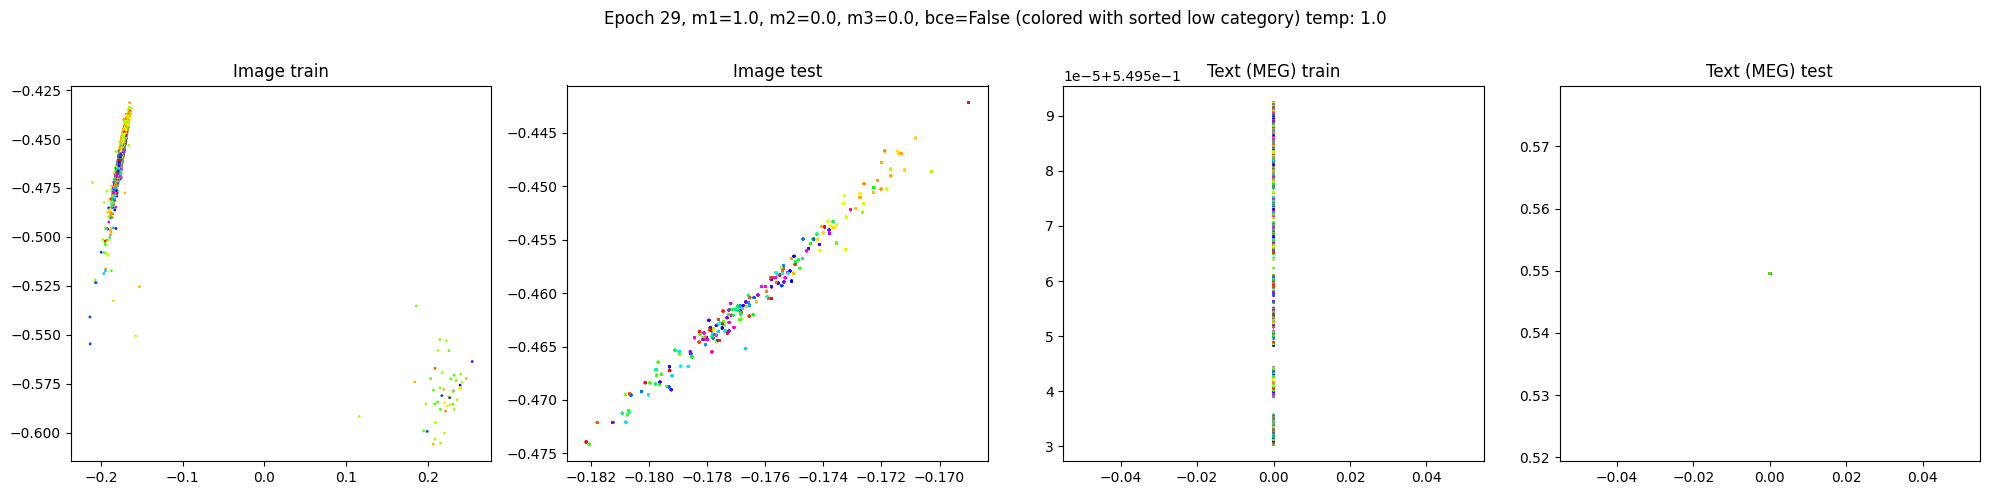

Best test acc: 0.00794956140350877 at epoch 0


In [14]:
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
model_temp_hist = []

best_test_acc = 0.0

epochs = 30
for i in range(epochs):
    
    train_losses = []
    train_accs = []
    
    train_images = []
    train_texts = []
    train_cats = []
    train_high_cats = []
    
    image_encoder.train()
    text_encoder.train()
    for images, texts, cats, high_cats in train_loader:        
        images, texts = images.to(device), texts.to(device)
        
        images = image_encoder(images)
        texts = text_encoder(texts)
        
        loss = clip_loss(images, texts)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        train_topk_accs = classifier(images, texts)[0]
        train_accs.append(train_topk_accs[0])
        
        train_images.append(images)
        train_texts.append(texts)
        train_cats.append(cats)
        train_high_cats.append(high_cats)
        
    train_images = torch.cat(train_images, dim=0).detach().cpu().numpy()
    train_texts = torch.cat(train_texts, dim=0).detach().cpu().numpy()
    train_cats = torch.cat(train_cats, dim=0).numpy()
    train_high_cats = torch.cat(train_high_cats, dim=0).numpy()
        
    test_losses = []
    test_accs = []
    
    test_images = []
    test_texts = []
    test_cats = []
    test_high_cats = []
        
    image_encoder.eval()
    text_encoder.eval()
    with torch.no_grad():
        for images, texts, cats, high_cats in test_loader:            
            images, texts = images.to(device), texts.to(device)
            
            images = image_encoder(images)
            texts = text_encoder(texts)
            
            loss = clip_loss(images, texts)
            test_losses.append(loss.item())
            
            test_topk_accs = classifier(images, texts)[0]
            test_accs.append(test_topk_accs[0])
            
            test_images.append(images)
            test_texts.append(texts)
            test_cats.append(cats)
            test_high_cats.append(high_cats)
            
    test_images = torch.cat(test_images, dim=0).detach().cpu().numpy()
    test_texts = torch.cat(test_texts, dim=0).detach().cpu().numpy()
    test_cats = torch.cat(test_cats, dim=0).numpy()
    test_high_cats = torch.cat(test_high_cats, dim=0).numpy()
            
    print(f"Epoch {i}: Train loss: {np.mean(train_losses):.3f} top-1 acc: {np.mean(train_accs):.3f}, Test loss: {np.mean(test_losses):.3f} top-1 acc: {np.mean(test_accs):.3f}")
    train_loss_hist.append(np.mean(train_losses))
    train_acc_hist.append(np.mean(train_accs))
    test_loss_hist.append(np.mean(test_losses))
    test_acc_hist.append(np.mean(test_accs))
    model_temp_hist.append(clip_loss.temp.item())
    
    if np.mean(test_accs) > best_test_acc:
        best_test_acc = np.mean(test_accs)
        best_epoch = i
        
        best_train_images = train_images
        best_train_texts = train_texts
        best_train_cats = train_cats
        best_test_images = test_images
        best_test_texts = test_texts
        best_test_cats = test_cats

    fig, ax = plt.subplots(1, 4, figsize=(20, 5), tight_layout=True)
    fig.suptitle(f"Epoch {i}, m1={m1}, m2={m2}, m3={m3}, bce={use_negatives} (colored with sorted low category) temp: {clip_loss.temp.item()}")
    ax[0].scatter(*train_images.T, c=sort_categories(train_cats), s=1, cmap="gist_rainbow")
    ax[0].set_title("Image train")
    ax[1].scatter(*test_images.T, c=sort_categories(test_cats), s=1, cmap="gist_rainbow")
    ax[1].set_title("Image test")
    ax[2].scatter(*train_texts.T, c=sort_categories(train_cats), s=1, cmap="gist_rainbow")
    ax[2].set_title("Text (MEG) train")
    ax[3].scatter(*test_texts.T, c=sort_categories(test_cats), s=1, cmap="gist_rainbow")
    ax[3].set_title("Text (MEG) test")
    display.clear_output(wait=True)
    display.display(fig)
    plt.close()
    
print(f"Best test acc: {best_test_acc} at epoch {best_epoch}")

Text(0.5, 1.0, 'Model temperature')

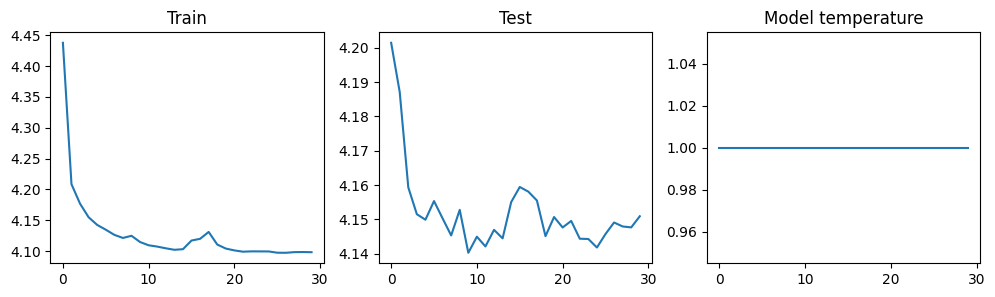

In [46]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
ax[0].plot(train_loss_hist)
ax[0].set_title("Train")
ax[1].plot(test_loss_hist)
ax[1].set_title("Test")
ax[2].plot(model_temp_hist)
ax[2].set_title("Model temperature")

Plot 2d latents

Text(0.5, 1.0, 'Text (MEG) test')

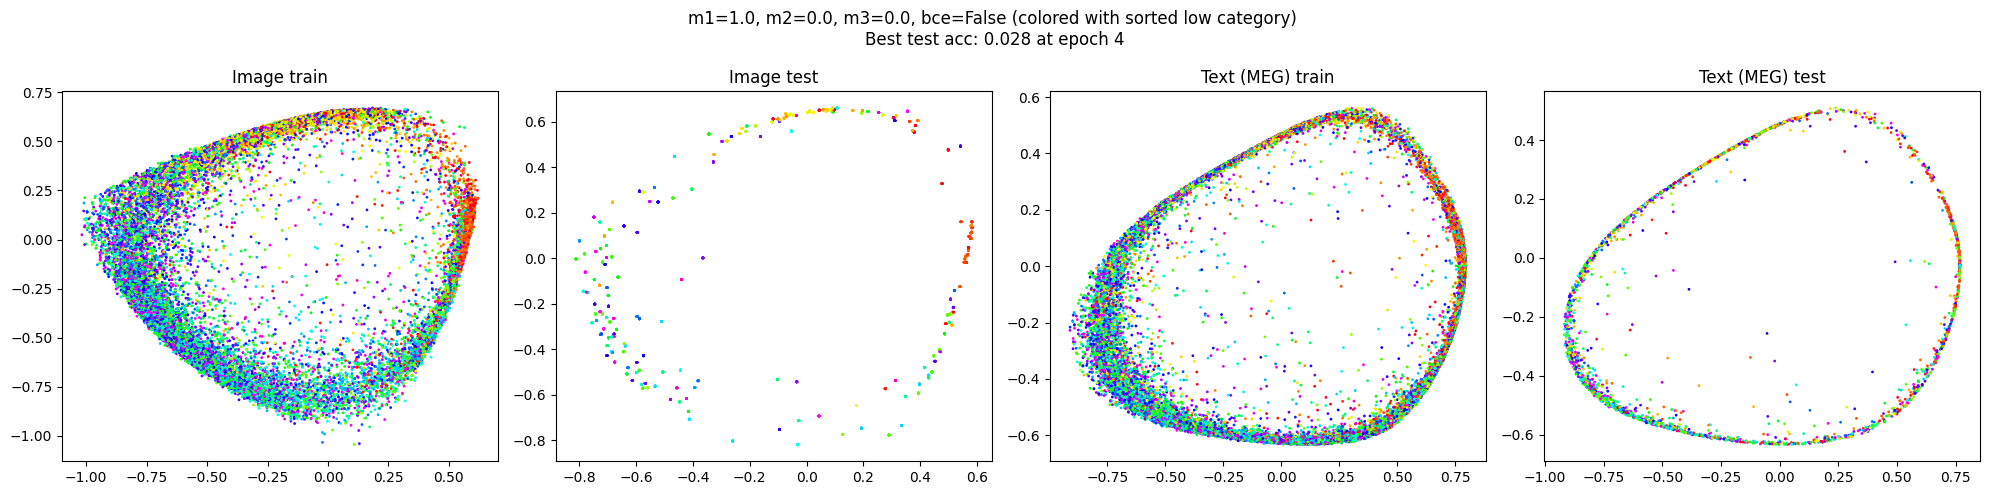

In [17]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), tight_layout=True)
fig.suptitle(f"m1={m1}, m2={m2}, m3={m3}, bce={use_negatives} (colored with sorted low category) \nBest test acc: {best_test_acc:.3f} at epoch {best_epoch}")

ax[0].scatter(*best_train_images.T, c=sort_categories(best_train_cats), s=1, cmap="gist_rainbow")
ax[0].set_title("Image train")
ax[1].scatter(*best_test_images.T, c=sort_categories(best_test_cats), s=1, cmap="gist_rainbow")
ax[1].set_title("Image test")
ax[2].scatter(*best_train_texts.T, c=sort_categories(best_train_cats), s=1, cmap="gist_rainbow")
ax[2].set_title("Text (MEG) train")
ax[3].scatter(*best_test_texts.T, c=sort_categories(best_test_cats), s=1, cmap="gist_rainbow")
ax[3].set_title("Text (MEG) test")

In [100]:
fig.savefig(f"../out/clip_2d_analysis/bce-{use_negatives}_m1-{m1}_m2-{m2}_m3-{m3}.png")

Plot norms

Text(0.5, 0.98, 'Train, bce=True, m1=1.0, m2=0.0, m3=0.3')

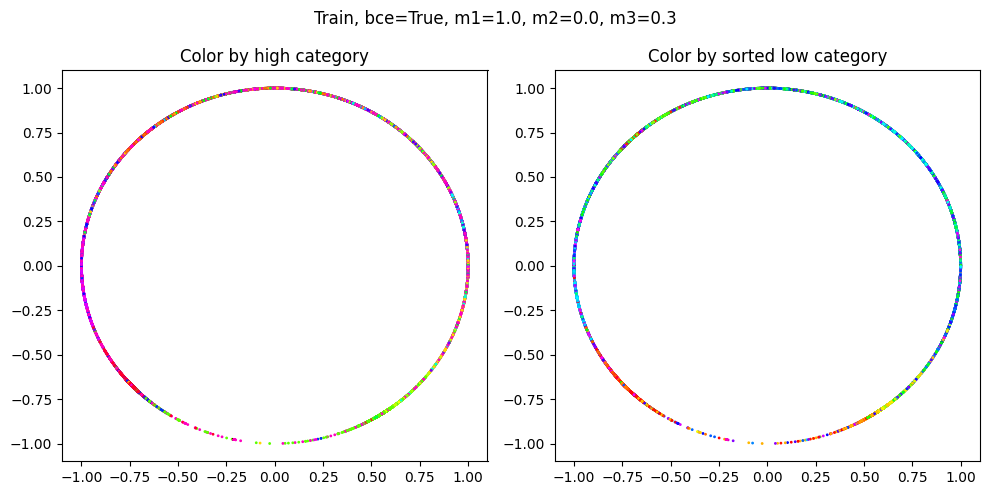

In [126]:
train_images_norm = train_images / np.linalg.norm(train_images, axis=1, keepdims=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

ax[0].scatter(*train_images_norm.T, c=train_high_cats, s=1, cmap="gist_rainbow")
ax[0].set_title("Color by high category")
ax[1].scatter(*train_images_norm.T, c=sort_categories(train_cats), s=1, cmap="gist_rainbow")
ax[1].set_title("Color by sorted low category")

fig.suptitle(f"Train, bce={use_negatives}, m1={m1}, m2={m2}, m3={m3}")

Plot cosine similarity distribution

torch.Size([27048, 27048])


(731594304,)
Median: 0.027, mean: 0.027


Text(0.5, 0, 'Cosine similarity')

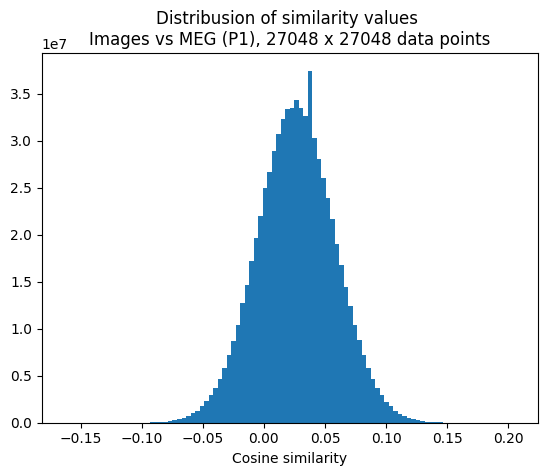

In [16]:
remove_diag = False

X_ = dataset.images.to(device)
Y_ = dataset.source.to(device)
X_ /= X_.norm(dim=-1, keepdim=True)
Y_ /= Y_.norm(dim=-1, keepdim=True)
sim = torch.matmul(X_, Y_.T)
print(sim.shape)

if remove_diag:
    b = sim.shape[0]
    sim = torch.cat(
        [torch.diag(sim, i) for i in range(1, b)]
        + [torch.diag(sim, -i) for i in range(1, b)]
    )
    assert len(sim) == b * (b - 1)
    
sim = sim.cpu().numpy().flatten()
print(sim.shape)
print(f"Median: {np.median(sim):.3f}, mean: {np.mean(sim):.3f}")

plt.hist(sim, bins=100)
plt.title("Distribusion of similarity values \nImages vs MEG (P1), 27048 x 27048 data points")
plt.xlabel("Cosine similarity")
# plt.legend()

Text(0.5, 0, 'Cosine similarity')

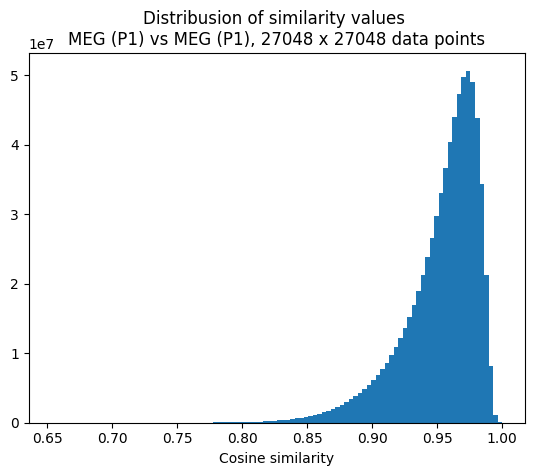

In [92]:
# X = dataset.images.to(device)
X = dataset.source.to(device)
X /= X.norm(dim=-1, keepdim=True)
sim = torch.matmul(X, X.T).cpu().numpy()

plt.hist(sim.flatten(), bins=100)
plt.title("Distribusion of similarity values \nMEG (P1) vs MEG (P1), 27048 x 27048 data points")
plt.xlabel("Cosine similarity")

Similarities of random vectors

Text(0.5, 0.92, '3D example')

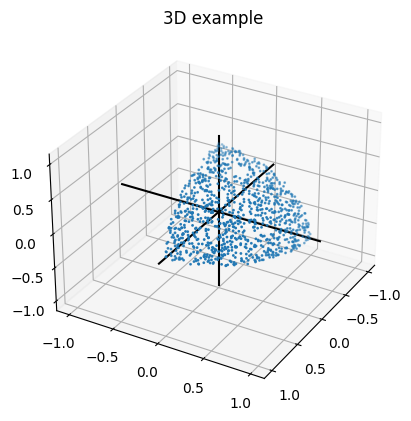

In [67]:
dist = HypersphericalUniformPS(dim=3).sample((1000,)).abs().numpy()
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(*dist.T, s=1)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_zlim(-1.1, 1.1)
ax.plot([0, 0], [0, 0], [-1.1, 1.1], c="black")
ax.plot([0, 0], [-1.1, 1.1], [0, 0], c="black")
ax.plot([-1.1, 1.1], [0, 0], [0, 0], c="black")
ax.view_init(30, 30)
ax.set_title("3D example")

Text(0.5, 0.98, 'Distribusion of similarity values \n Hyperspherical uniform (only positive region), 1000 x 1000 data points')

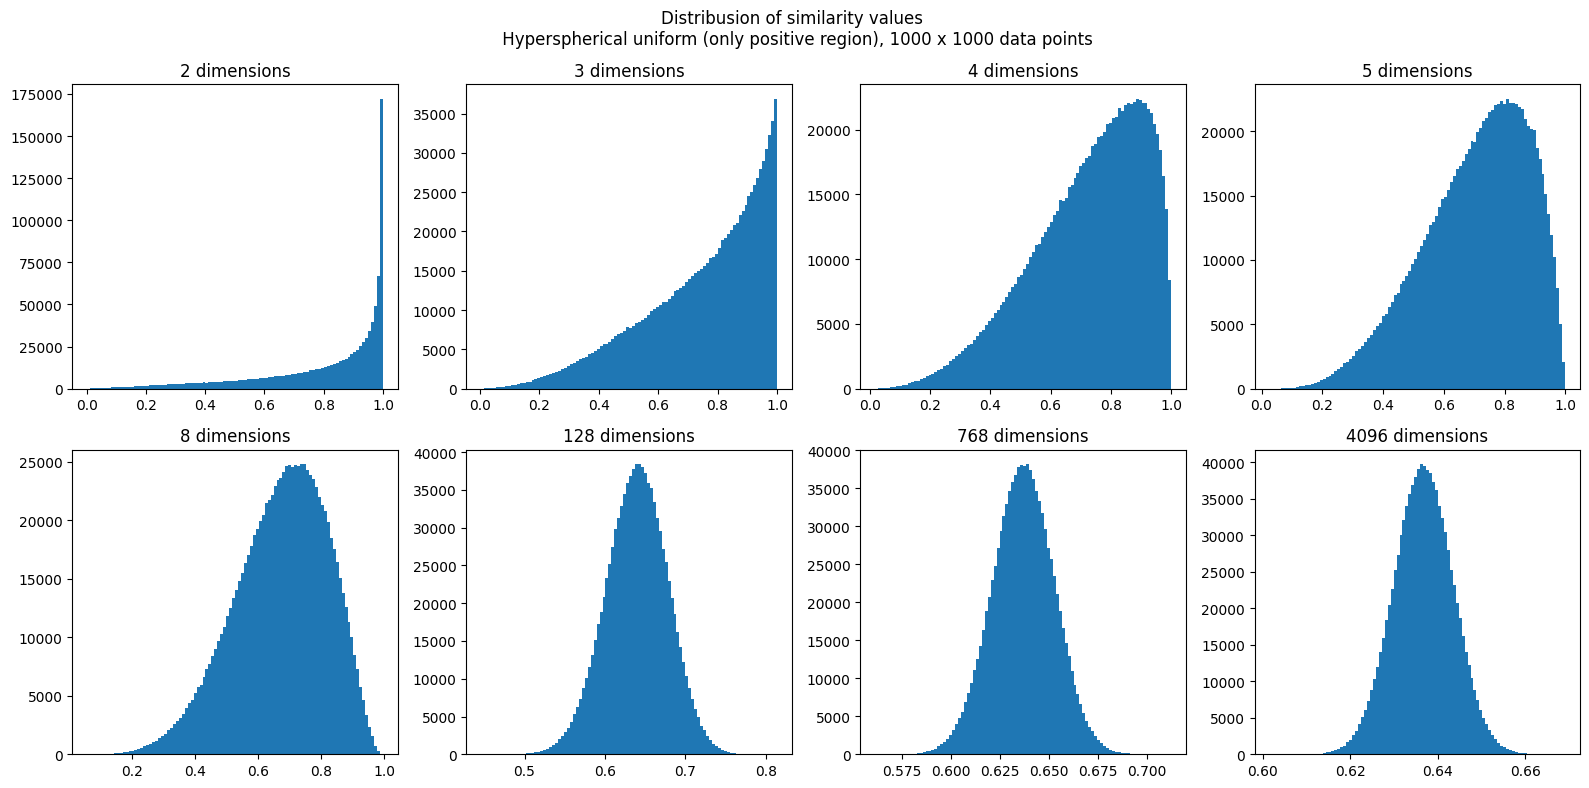

In [42]:
dims = [2, 3, 4, 5, 8, 128, 768, 4096]

fig, axs = plt.subplots(2, 4, figsize=(16, 8), tight_layout=True)

for i, dim in enumerate(dims):
    dist = HypersphericalUniformPS(dim=dim)
    
    X = dist.sample((1000,)).abs()
    Y = dist.sample((1000,)).abs()

    X /= X.norm(dim=-1, keepdim=True)
    Y /= Y.norm(dim=-1, keepdim=True)

    sim = torch.matmul(X, Y.T).cpu().numpy()
    
    ax = axs[i // 4, i % 4]
    ax.hist(sim.flatten(), bins=100)
    ax.set_title(f"{dim} dimensions")

fig.suptitle("Distribusion of similarity values \n Hyperspherical uniform (only positive region), 1000 x 1000 data points")

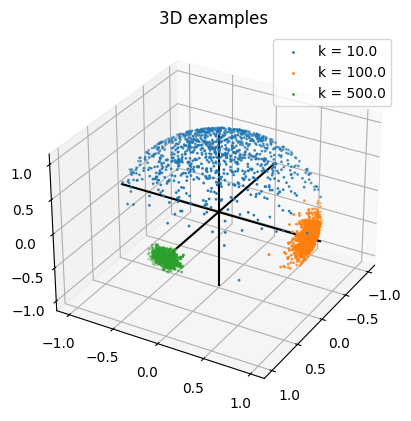

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

locs = [[0., 0., 1.], [0., 1., 0.], [1., 0., 0.]]
scales = [10., 100., 500.]

for loc, scale in zip(locs, scales):
    dist = PowerSpherical(
        loc=torch.tensor(loc, requires_grad=True),
        scale=torch.tensor(scale, requires_grad=True)
    )
    samples = dist.sample((1000,)).numpy()
    ax.scatter(*samples.T, s=1, label=f"k = {scale}")
    
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_zlim(-1.1, 1.1)
ax.plot([0, 0], [0, 0], [-1.1, 1.1], c="black")
ax.plot([0, 0], [-1.1, 1.1], [0, 0], c="black")
ax.plot([-1.1, 1.1], [0, 0], [0, 0], c="black")
ax.view_init(30, 30)
ax.set_title("3D examples")
plt.legend()

torch.Size([4, 3]) torch.Size([4])
(1000, 4, 3)


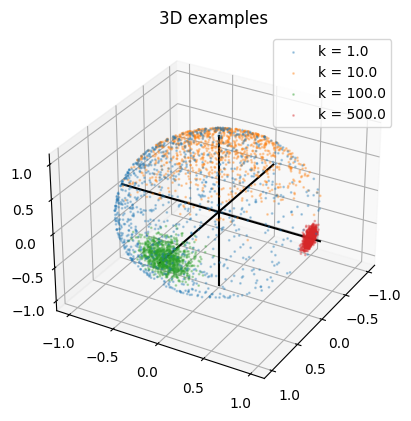

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

loc = torch.tensor([[0., -1., 0.], [0., 0., 1.], [1., 0., 0.], [0., 1., 0.]], requires_grad=True)
scale = torch.tensor([1., 10., 100., 500.], requires_grad=True)
print(loc.shape, scale.shape)

dist = PowerSpherical(loc=loc, scale=scale)
samples = dist.sample((1000,)).numpy()
print(samples.shape)

for k in range(samples.shape[1]):
    ax.scatter(*samples[:, k].T, s=1, label=f"k = {scale[k]}", alpha=0.3)
    
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_zlim(-1.1, 1.1)
ax.plot([0, 0], [0, 0], [-1.1, 1.1], c="black")
ax.plot([0, 0], [-1.1, 1.1], [0, 0], c="black")
ax.plot([-1.1, 1.1], [0, 0], [0, 0], c="black")
ax.view_init(30, 30)
ax.set_title("3D examples")
plt.legend()

In [3]:
# loc = torch.tensor([[0., -1., 0.], [0., 0., 1.], [1., 0., 0.], [0., 1., 0.]], requires_grad=True)
# scale = torch.tensor([1., 10., 100., 500.], requires_grad=True)
# loc = torch.tensor([0., -1., 0.], requires_grad=True)
# scale = torch.tensor(10., requires_grad=True)
loc = torch.rand(3)
scale = torch.tensor(1.0, requires_grad=True)

p = PowerSpherical(loc=loc, scale=scale)

q = HypersphericalUniform(dim=3)
# q = PowerSpherical(loc=torch.zeros(3), scale=torch.tensor(1.0))
print(torch.distributions.kl_divergence(p, q))

tensor(0.1931, grad_fn=<AddBackward0>)


Scale 10.0, sim median: 0.000, sim mean: 0.000
Scale 100.0, sim median: 0.013, sim mean: 0.013
Scale 1000.0, sim median: 0.320, sim mean: 0.320
Scale 10000.0, sim median: 0.863, sim mean: 0.862


Text(0.5, 0.98, 'Distribusion of similarity values \n Hyperspherical normal, 1000 x 1000 data points')

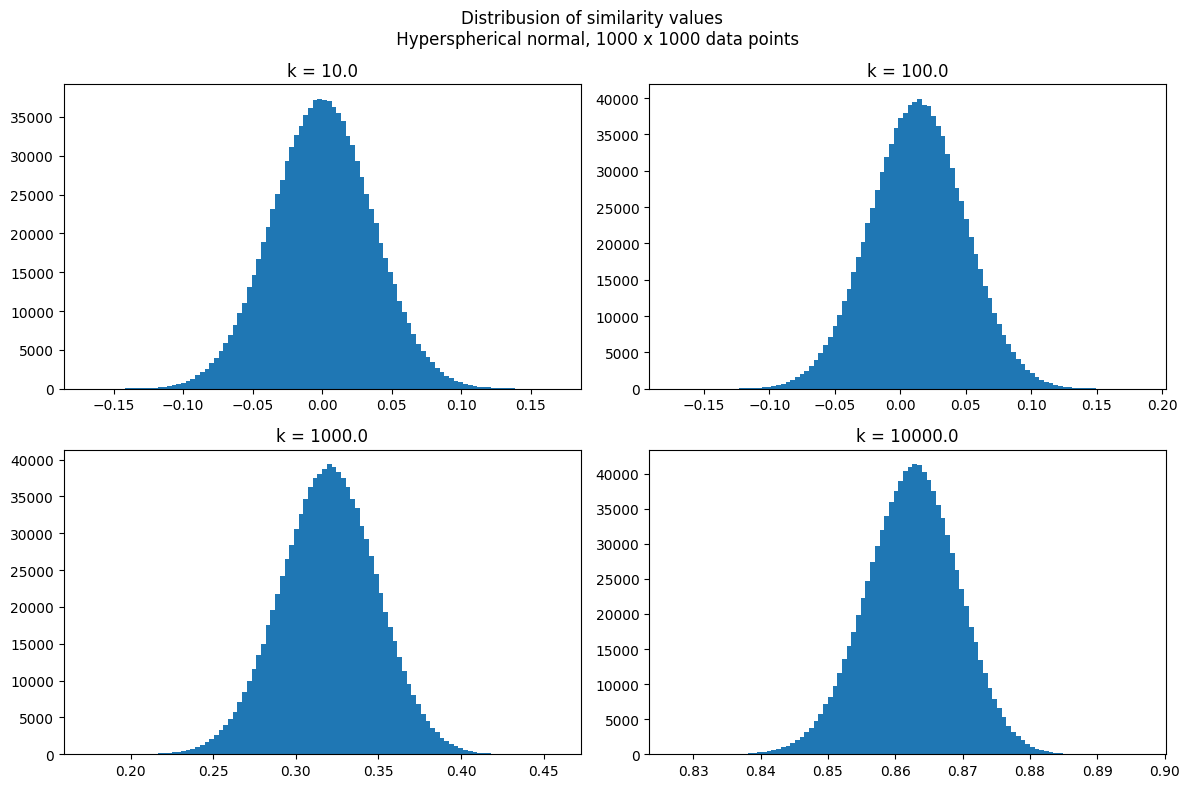

In [20]:
scales = [10.0, 100.0, 1000.0, 1e4]

fig, axs = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)

loc = torch.zeros(768)
loc[0] = 1
loc.requires_grad = True

for i, scale in enumerate(scales):
    dist = PowerSpherical(
        loc=loc,
        scale=torch.tensor(scale, requires_grad=True)
    )
    
    X = dist.sample((1000,))
    Y = dist.sample((1000,))

    X /= X.norm(dim=-1, keepdim=True)
    Y /= Y.norm(dim=-1, keepdim=True)

    sim = torch.matmul(X, Y.T).cpu().numpy().flatten()
    
    ax = axs[i // 2, i % 2]
    ax.hist(sim, bins=100)
    ax.set_title(f"k = {scale}")
    
    print(f"Scale {scale}, sim median: {np.median(sim):.3f}, sim mean: {np.mean(sim):.3f}")

fig.suptitle("Distribusion of similarity values \n Hyperspherical normal, 1000 x 1000 data points")

Vector values

Text(0.5, 1.0, 'BrainEncoder (conformer)')

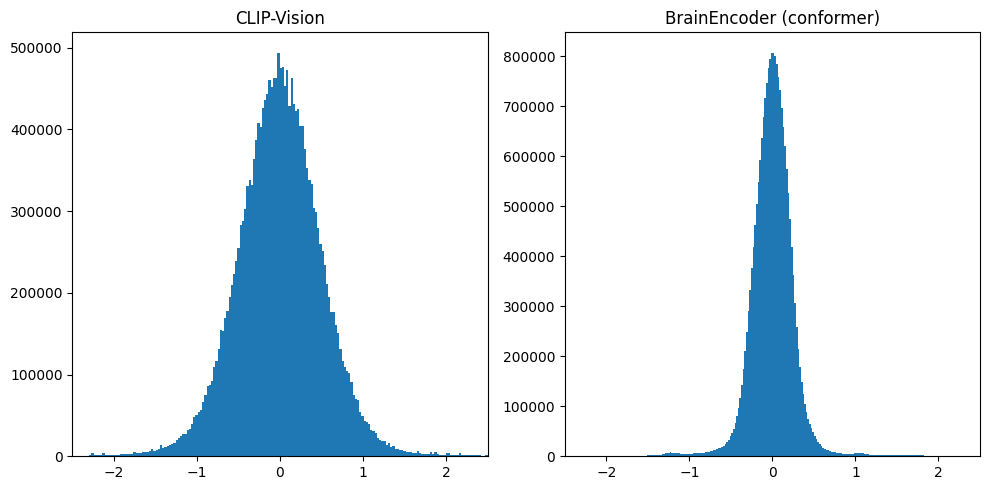

In [31]:
values_source = dataset.source.flatten().numpy()
values_target = dataset.images.flatten().numpy()

fig, ax = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
# ax[0].set_ylim([0, 3000])
ax[0].set_xlim([-2.5, 2.5])
ax[0].hist(values_target, bins=1000)
ax[0].set_title("CLIP-Vision")
# ax[1].set_ylim([0, 3000])
ax[1].set_xlim([-2.5, 2.5])
ax[1].hist(values_source, bins=1000)
ax[1].set_title("BrainEncoder (conformer)")

Norms

Text(0.5, 0, 'Norm values')

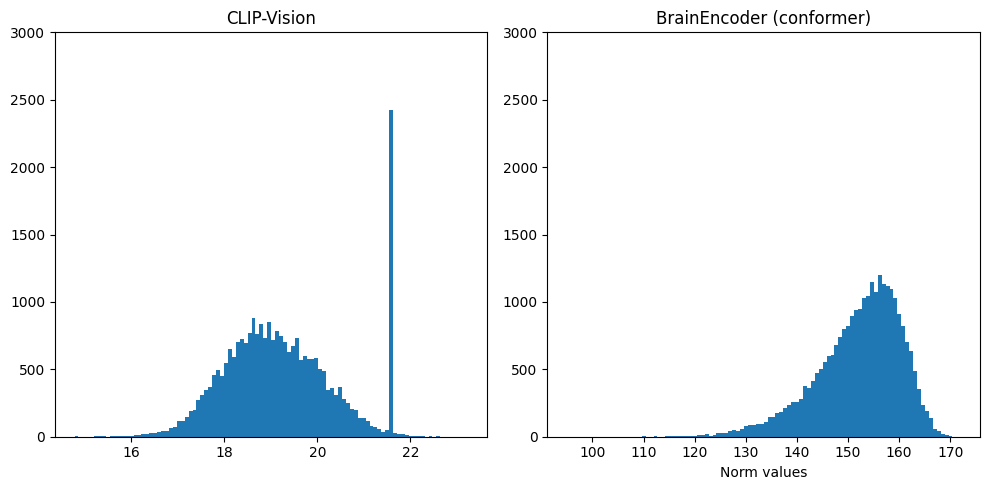

In [30]:
norm_source = dataset.source.norm(dim=-1).numpy()
norm_target = dataset.images.norm(dim=-1).numpy()
fig, ax = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
ax[0].hist(norm_target, bins=100)
ax[0].set_ylim([0, 3000])
ax[0].set_title("CLIP-Vision")
ax[1].hist(norm_source, bins=100)
ax[1].set_ylim([0, 3000])
ax[1].set_title("BrainEncoder (conformer)")
ax[1].set_xlabel("Norm values")

Plot originals from TSNE

In [ ]:
train_images_tsne = TSNE(n_components=2, perplexity=30).fit_transform(train_orig_images)

Text(0.5, 1.0, 'Color by sorted category')

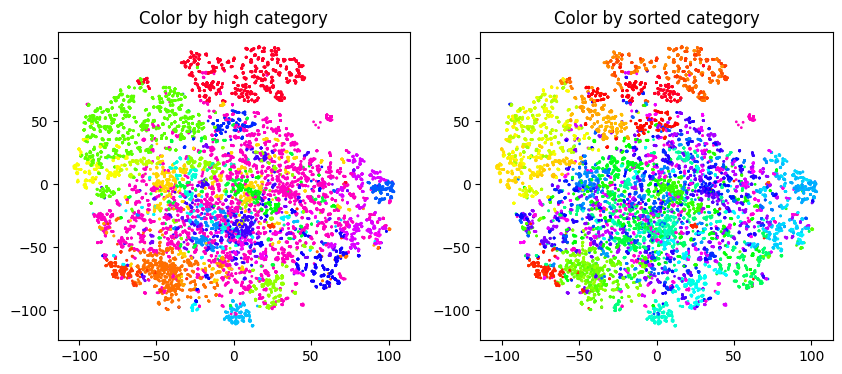

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(*train_images_tsne.T, c=train_high_cats, s=1, cmap="gist_rainbow")
ax[0].set_title("Color by high category")

ax[1].scatter(*train_images_tsne.T, c=sort_categories(train_cats), s=1, cmap="gist_rainbow")
ax[1].set_title("Color by sorted category")

Visualize spherical uniform

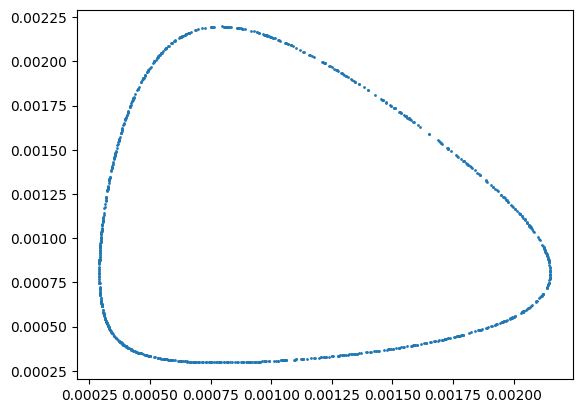

In [49]:
dist = HypersphericalUniform(dim=2)
samples1 = F.softmax(dist.sample((1000,)), dim=0)
plt.scatter(*samples1.T, s=1)

In [52]:
samples1 = dist.sample((1000,))
samples2 = dist.sample((1000,))

kl1 = F.kl_div(samples1.log_softmax(dim=0), samples2.softmax(dim=0), reduction="batchmean")
kl2 = F.kl_div(samples1.abs().log_softmax(dim=0), samples2.softmax(dim=0), reduction="batchmean")
print(kl1, kl2)

kl1 = F.kl_div(samples1.log_softmax(dim=-1), samples2.softmax(dim=-1), reduction="batchmean")
kl2 = F.kl_div(samples1.abs().log_softmax(dim=-1), samples2.softmax(dim=-1), reduction="batchmean")
print(kl1, kl2)

tensor(0.0009) tensor(0.0005)
tensor(0.2332) tensor(0.1496)


Trying to get bases for classes

In [10]:
class SparseCLIPLoss(nn.Module):
    def __init__(self, K: int, reduction="mean") -> None:
        super().__init__()
        
        self.ce = nn.CrossEntropyLoss(reduction=reduction)
        
        self.W = nn.Embedding(K, 768)
        self.W.weight.data.normal_()

    def forward(self, X: torch.Tensor, Y: torch.Tensor, classes) -> torch.Tensor:
        b = X.shape[0]

        X = X.reshape(b, -1)
        Y = Y.reshape(b, -1)

        X = X / X.norm(dim=-1, keepdim=True)
        Y = Y / Y.norm(dim=-1, keepdim=True)
        W = self.W.weight / self.W.weight.norm(dim=-1, keepdim=True)
        
        sim_x = torch.matmul(X, W.T) # ( b, K )
        # classes = sim_x.argmax(dim=-1) # ( b, )
        
        loss = self.ce(sim_x, classes)
        
        # avg_probs = F.softmax(sim_x, dim=-1).mean(dim=0) # ( K, )
        # perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-7), dim=-1)).sum()

        return loss #  + perplexity

In [11]:
K = 28

device = "cuda:0"

dataset = CLIPLatentsDatset()
train_set = torch.utils.data.Subset(dataset, dataset.train_idxs)
test_set = torch.utils.data.Subset(dataset, dataset.test_idxs)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

clip_loss = SparseCLIPLoss(K=K).to(device)

optimizer = torch.optim.Adam(clip_loss.parameters(), lr=5e-4)

100%|██████████| 174/174 [00:00<00:00, 262.33it/s]
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/sensho/anaconda3/envs/nd/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/sensho/anaconda3/envs/nd/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/sensho/anaconda3/envs/nd/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', s

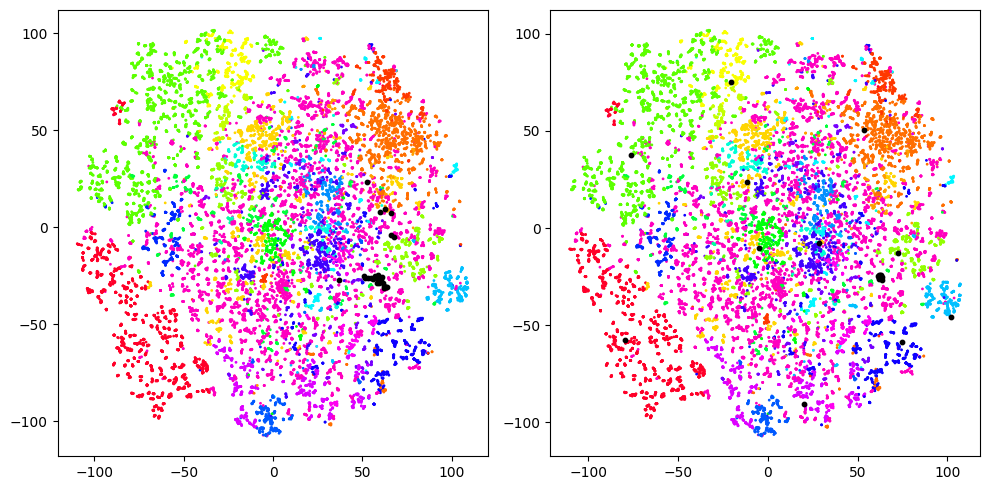

In [12]:
init_images_list = []
init_high_cats_list = []
final_images_list = []
final_high_cats_list = []

init_bases = clip_loss.W.weight.data.cpu().numpy()

epochs = 10
for i in range(epochs):    
    for images, texts, cats, high_cats in tqdm(train_loader):
        images, texts = images.to(device), texts.to(device)
        high_cats = high_cats.to(device)
        
        loss = clip_loss(images, texts, high_cats)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i == 0:
            init_images_list.append(images.detach().cpu().numpy())
            init_high_cats_list.append(high_cats.detach().cpu().numpy())
        elif i == epochs - 1:
            final_bases = clip_loss.W.weight.data.cpu().numpy()
            
            final_images_list.append(images.detach().cpu().numpy())
            final_high_cats_list.append(high_cats.detach().cpu().numpy())
            
init_images_list.append(init_bases)
final_images_list.append(final_bases)
            
init_images = np.concatenate(init_images_list, axis=0)
init_high_cats = np.concatenate(init_high_cats_list, axis=0)
final_images = np.concatenate(final_images_list, axis=0)
final_high_cats = np.concatenate(final_high_cats_list, axis=0)

init_images = TSNE(n_components=2, perplexity=30).fit_transform(init_images)
final_images = TSNE(n_components=2, perplexity=30).fit_transform(final_images)

init_images, init_bases = np.split(init_images, [-K])
final_images, final_bases = np.split(final_images, [-K])

fig, ax = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
ax[0].scatter(*init_images.T, c=init_high_cats, s=1, cmap="gist_rainbow")
ax[0].scatter(*init_bases.T, c="black", s=10)
ax[1].scatter(*final_images.T, c=final_high_cats, s=1, cmap="gist_rainbow")
ax[1].scatter(*final_bases.T, c="black", s=10)

In [32]:
init_bases

array([[ 53.918224  , -24.740286  ],
       [ 58.54782   ,   7.367137  ],
       [ 72.38433   , -27.66668   ],
       [ 80.45606   , -76.29534   ],
       [ 71.53537   , -28.177528  ],
       [ 69.58716   , -30.308167  ],
       [ 50.841206  ,  20.25621   ],
       [ 63.866566  ,   5.069854  ],
       [ 65.041504  , -30.583963  ],
       [ 70.265015  ,   0.18053463],
       [ 73.429924  , -26.587051  ],
       [ 52.084415  ,  21.241207  ],
       [ 75.67639   ,  57.060734  ],
       [ 51.93677   , -24.40941   ],
       [ 64.841835  ,   6.7117496 ],
       [ 69.371086  ,   3.589061  ],
       [-23.214235  ,  29.876553  ],
       [ -1.494372  , -49.44327   ],
       [  0.8257625 , -15.297406  ],
       [ -1.5201746 , -49.3973    ]], dtype=float32)

In [33]:
final_bases

array([[112.566124  ,   0.8617939 ],
       [  1.0710375 ,  22.748762  ],
       [112.56062   ,   0.8623844 ],
       [112.5651    ,   0.8616745 ],
       [112.55709   ,   0.86709934],
       [112.71697   ,   0.7681771 ],
       [112.5634    ,   0.8641151 ],
       [112.55851   ,   0.86387485],
       [  0.94620955,  22.793411  ],
       [112.54515   ,   0.8741134 ],
       [112.53393   ,   0.87864375],
       [112.56454   ,   0.8620279 ],
       [  1.0532837 ,  22.771023  ],
       [112.54338   ,   0.8817285 ],
       [112.55802   ,   0.86702365],
       [112.56097   ,   0.86345834],
       [  1.0408202 ,  22.758873  ],
       [112.56022   ,   0.8651679 ],
       [112.55499   ,   0.87250423],
       [112.56822   ,   0.860441  ]], dtype=float32)